# <center> Predict Costs of Prodction Parts  </center>

## <center> Khanh TRUONG </center>
##### <center> August 2019 </center>

*<center> The goal of this project is to predict costs of parts given technical drivers. Afterwards, using error distribution to assess degree of confidence on Test sample. </center>*

### Table of Contents:
1. Prepare data
2. Descriptive statistics
3. Distance definition
4. DBSCAN
5. Visualization
6. Define standard processes

# =============================================================

# Import libraries

In [1]:
import numpy as np
import pandas as pd

# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.gridspec as gridspec

import ipywidgets as widgets
from ipywidgets import interactive, interact, HBox, Layout, VBox
from IPython.display import display

import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib # saving GridSearchCV

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from scipy.stats import percentileofscore
import pickle # for saving

# Costs and Technical Drivers data are not perfectly matched

In [2]:
reference1 = pd.read_excel('01_Input/Reference sample.xlsx', sheet_name='Costing Detail')
reference1 = reference1[['partNumber', 'Total Labor Cost/PN', 'Total Material Cost/PN', 'Total Cost/PN']]
reference2 = pd.read_excel('01_Input/Reference sample.xlsx', sheet_name='Tech. Drivers')
reference = pd.merge(reference1, reference2, how='left', left_on='partNumber', right_on='partNumber')
reference.head()

,partNumber,Total Labor Cost/PN,Total Material Cost/PN,Total Cost/PN,costingGroup,Part Category for assembly operation,Designation,Material Fly Weight [kg],Length,Width,...,Nb of bonding point [Qty],Surface protection code (DPT),Nb of holes for DPT treat,Bounding Box Volume,Finished part Volume,Material Removed Prep Milling,Machining In Opposite Direction,Material Removed Surface Milling,Material Removed Pockets,Material Removed Final
0,t0001,28.025379,8.115966,36.141345,MACH_VSB_AL,BEARING,BEARING FLANGE,0.0122,77.159595,72.544148,...,NaN,NaN,3,2.402722e+04,4254.753125,0.097328,True,0.136259,0.000000,0.031400
1,t0002,23.756553,7.565814,31.322367,MACH_VSB_AL,NaN,SPACER,0.0187,45.000000,45.000000,...,NaN,451,3,1.562500e+04,6916.387319,0.028350,False,0.028350,0.000000,0.025050
2,t0003,26.584484,7.561053,34.145537,MACH_VSB_AL,NaN,HINGE,0.0150,55.000663,50.559682,...,NaN,451,1,1.497695e+04,2304.781095,0.039270,True,0.047106,0.002896,0.023700
3,t0004,22.939686,7.430709,30.370394,MACH_VSB_AL,NaN,SLIDER,0.0250,57.696667,42.016162,...,NaN,456,1,7.427927e+03,3057.623048,0.034104,False,0.041266,0.000000,0.000000
4,t0005,60.857918,32.989999,93.847917,MACH_SB_AL,NaN,PIVOT ARM CTR LH,0.5722,409.687280,154.444918,...,NaN,456,13,2.148051e+06,204197.928400,0.949312,True,0.759449,0.000000,2.286085


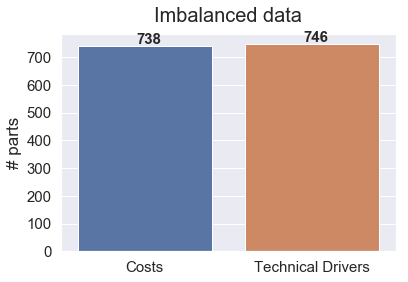

In [3]:
ax = sns.barplot(x = ['Costs', 'Technical Drivers'],
                 y = [reference1.shape[0], reference2.shape[0]])
plt.title('Imbalanced data', size=20, pad=12)
plt.ylabel('# parts', size=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

for i, v in enumerate([reference1.shape[0], reference2.shape[0]]):
    ax.text(i-0.05, v + 10, str(v), fontweight='bold', size=15)

In [4]:
s = list(reference1['partNumber'])
t = list(reference2['partNumber'])
print('Parts that do not have costs information: {}'.format([x for x in t if x not in s]))

Parts that do not have costs information: ['t0026', 't0102', 't0178', 't0326', 't0327', 't0328', 't0329', 't0332']


In [5]:
(reference['Total Labor Cost/PN']/reference['Total Cost/PN']).describe()

count    738.000000
mean       0.679116
std        0.091592
min        0.335623
25%        0.634103
50%        0.702299
75%        0.751394
max        0.853975
dtype: float64

# Majority of 2 variables are missing values

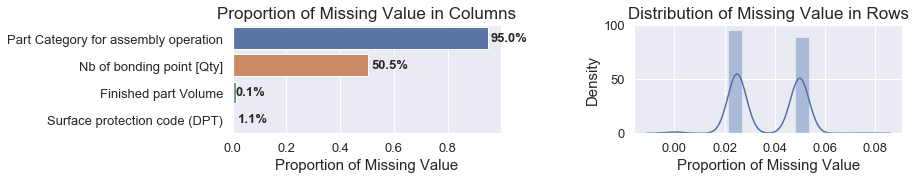

In [6]:
# Count missing in every column and row
na_col = reference.isna().sum(axis=0).divide(reference.shape[0])
na_col = na_col[na_col>0]
na_row = reference.isna().sum(axis=1).divide(reference.shape[1])

plt.figure(figsize=(12, 2))

plt.subplot(1, 2, 1)
ax = sns.barplot(x=na_col.sort_values(ascending=False),
            y=na_col.sort_values(ascending=False).index)
plt.title('Proportion of Missing Value in Columns', size=17)
plt.xlabel('Proportion of Missing Value', size=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);
for i, v in enumerate(na_col):
    ax.text(v+0.01, i+0.1, "{0:.1%}".format(v), fontweight='bold', size=13);

plt.subplot(1, 2, 2)
plt.subplots_adjust(wspace=0.5)
sns.distplot(na_row)
plt.title('Distribution of Missing Value in Rows', size=17)
plt.xlabel('Proportion of Missing Value', size=15)
plt.ylabel('Density', size=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

In [7]:
imp = Imputer(missing_values=np.nan, strategy="median", axis=0)
reference["Nb of bonding point [Qty]"] = imp.fit_transform(reference[["Nb of bonding point [Qty]"]]).ravel()

imp = Imputer(missing_values=np.nan, strategy="mean", axis=0)
reference["Finished part Volume"] = imp.fit_transform(reference[["Finished part Volume"]]).ravel()

reference = reference.drop(['Part Category for assembly operation', 'Surface protection code (DPT)'], axis=1)

C:\Users\truong_ph\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\truong_ph\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Categorical variables do not bring much information

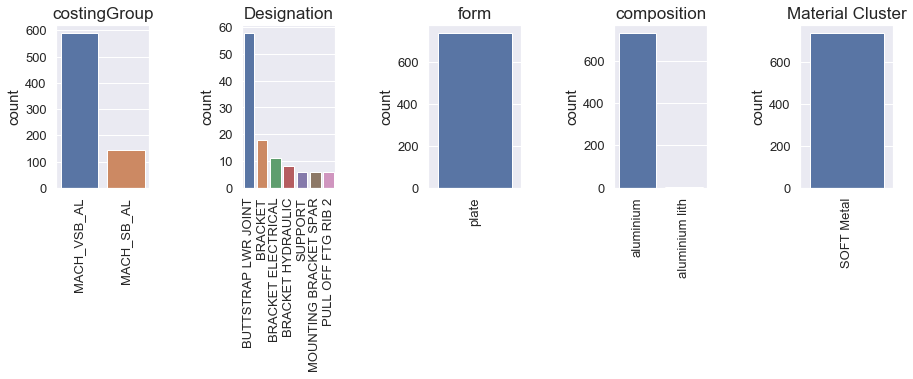

In [8]:
# Display number of parts in every class of categorical variables

plt.figure(figsize=(15, 3))
for i in enumerate(reference.dtypes[reference.dtypes=='object'].index[1:6]):
    plt.subplots_adjust(wspace=1)
    plt.subplot(1, 5, i[0] + 1)
    sns.barplot(y=reference[i[1]].value_counts()[0:7],
                x=list(reference[i[1]].value_counts()[0:7].index.astype('str')))
    plt.title(i[1], size=17)
    plt.xlabel('', size=15)
    plt.ylabel('count', size=15)
    plt.xticks(rotation=90, fontsize=13)
    plt.yticks(fontsize=13);

# =============================================================

# All numeric variables seem to be usable information

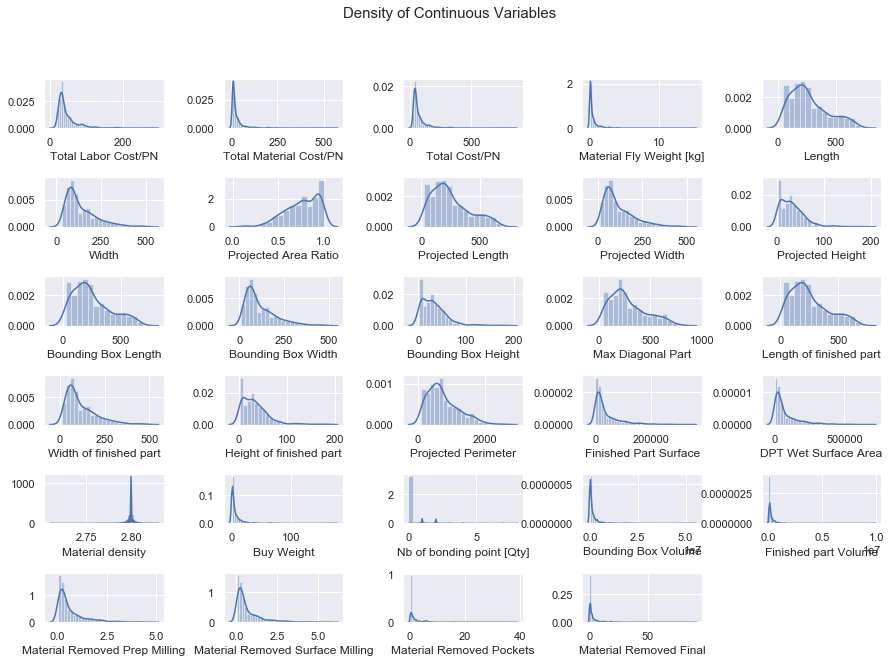

In [9]:
# Density of numeric (continuous) variables

reference_num = reference[reference.dtypes[reference.dtypes=='float64'].index]
plt.figure(figsize=(15,10))
for i in enumerate(reference_num.columns):
    plt.subplot(6, 5, i[0] + 1)
    plt.subplots_adjust(hspace=1, wspace=0.5)
    sns.distplot(reference_num[i[1]])
plt.suptitle('Density of Continuous Variables', size=15);

# Detect Collinearity using correlation matrix

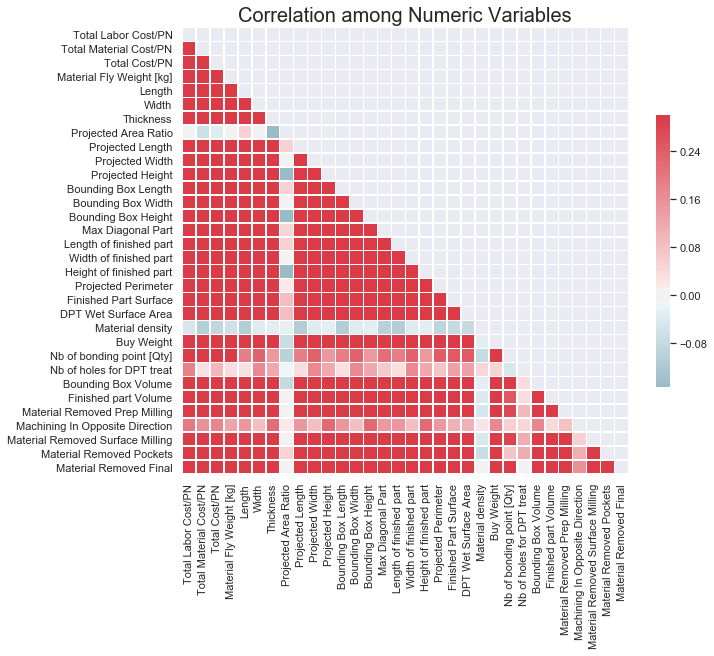

In [10]:
# Correlation among variables

# Compute the correlation matrix
corr = reference.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation among Numeric Variables', size=20);

# Detect Multicolinearity using Variance Inflation Factor (VIF)

In [11]:
independent_var = [x for x in reference_num.columns if x not in ['Total Labor Cost/PN', 'Total Material Cost/PN', 'Total Cost/PN']]
reference_X = reference[independent_var]

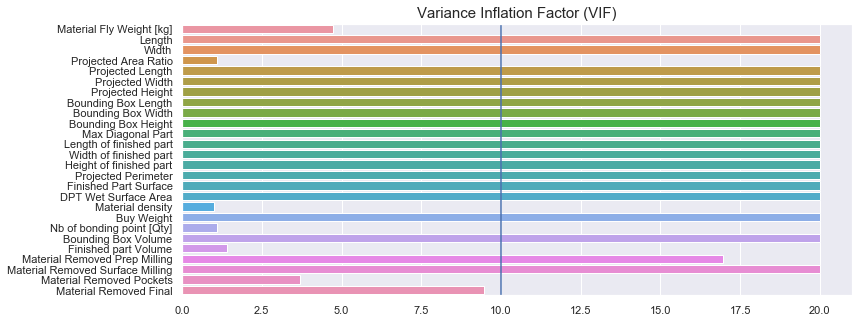

In [12]:
np.seterr(divide='ignore')
vif_list = []

for i in range(0, len(independent_var)):
    y = reference_X.loc[:, reference_X.columns == independent_var[i]]
    X = reference_X.loc[:, reference_X.columns != independent_var[i]]
    regression = LinearRegression().fit(X, y)
    rsq = regression.score(X, y)
    vif = round(1 / (1 - rsq**2), 2)
    vif_list.append(vif)
    
vif_list_edit = [20 if x>20 else x for x in vif_list] 
plt.figure(figsize=(12,5))
sns.barplot(x=vif_list_edit, y=independent_var)
plt.axvline(x=10)
plt.title('Variance Inflation Factor (VIF)', size=15);

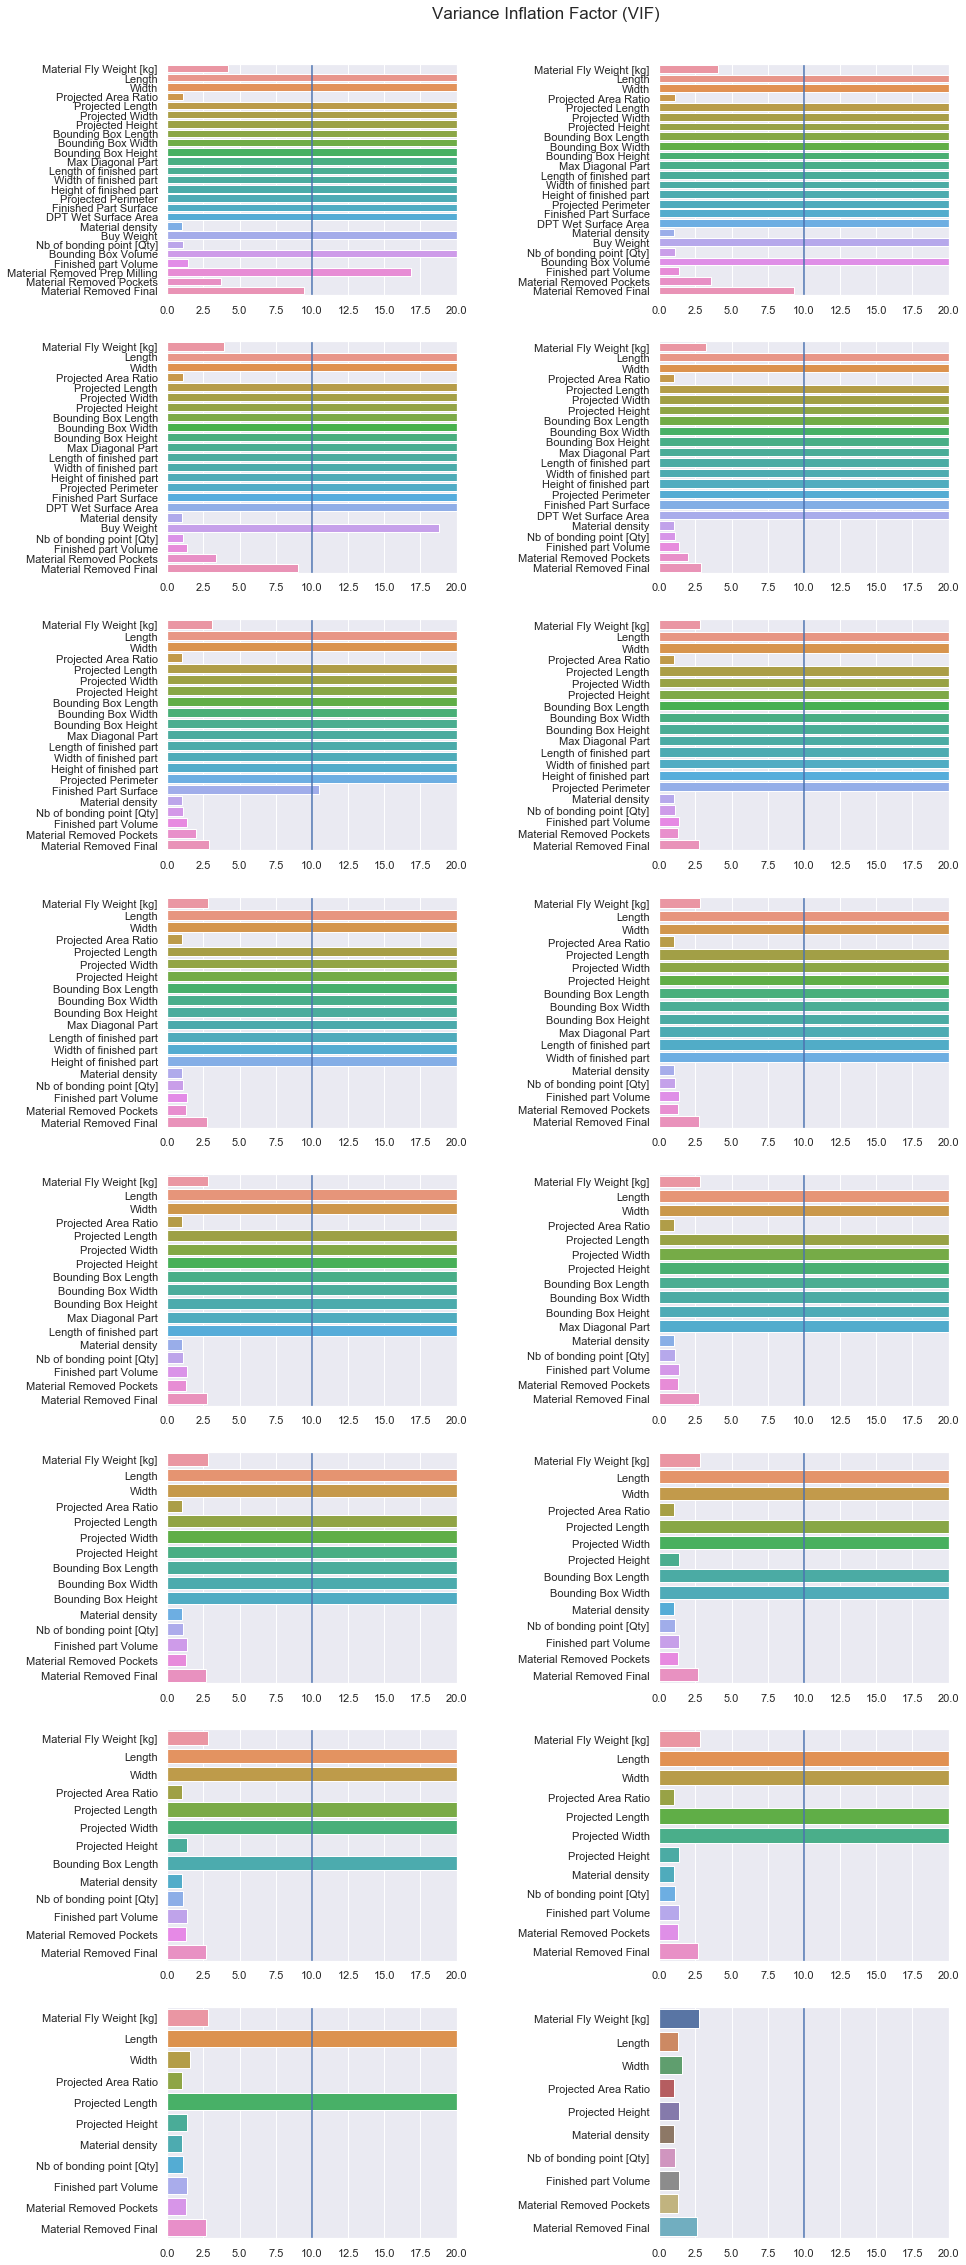

In [13]:
fig = plt.figure(figsize=(14,40))
fig.suptitle('Variance Inflation Factor (VIF)', size=17, y=0.9)

position = 0

while sum([1 if x>10 else 0 for x in vif_list_edit])>0:
    position += 1
    m = max(vif_list)
    # max_index = [i for i, j in enumerate(vif_list) if j == m]
    # max_index
    max_index = [i for i, j in enumerate(vif_list) if j > 10]
    
    # del independent_var[random.choice(max_index)]
    del independent_var[np.max(max_index)]
    reference_X = reference_X[independent_var]

    vif_list = []

    for i in range(0, len(independent_var)):
        y = reference_X.loc[:, reference_X.columns == independent_var[i]]
        X = reference_X.loc[:, reference_X.columns != independent_var[i]]
        regression = LinearRegression().fit(X, y)
        rsq = regression.score(X, y)
        vif = round(1 / (1 - rsq**2), 2)
        vif_list.append(vif)

    vif_list_edit = [20 if x>20 else x for x in vif_list]

    plt.subplot(8, 2, position)
    plt.subplots_adjust(hspace=0.2, wspace=0.7)
    ax = sns.barplot(x=vif_list_edit, y=independent_var)
    ax.set_xlim([0, 20]) 
    plt.axvline(x=10);

In [14]:
reference_X.head()

,Material Fly Weight [kg],Length,Width,Projected Area Ratio,Projected Height,Material density,Nb of bonding point [Qty],Finished part Volume,Material Removed Pockets,Material Removed Final
0,0.0122,77.159595,72.544148,0.630369,8.000000,2.8,0.0,4254.753125,0.000000,0.031400
1,0.0187,45.000000,45.000000,1.000000,25.000000,2.8,0.0,6916.387319,0.000000,0.025050
2,0.0150,55.000663,50.559682,0.991915,14.748764,2.8,0.0,2304.781095,0.002896,0.023700
3,0.0250,57.696667,42.016162,0.622091,8.950001,2.8,0.0,3057.623048,0.000000,0.000000
4,0.5722,409.687280,154.444918,0.470525,41.000025,2.8,0.0,204197.928400,0.000000,2.286085


# =============================================================

### Train and test sets split

In [15]:
# Split into train set and test set
X_train, X_test, y_train_labor, y_test_labor = train_test_split(reference_X,
                                                                reference['Total Labor Cost/PN'],
                                                                test_size = 0.2,
                                                                random_state = 42)

# Split into train set and test set
X_train, X_test, y_train_material, y_test_material = train_test_split(reference_X,
                                                                      reference['Total Material Cost/PN'],
                                                                      test_size = 0.2,
                                                                      random_state = 42)

# Split into train set and test set
X_train, X_test, y_train_total, y_test_total = train_test_split(reference_X,
                                                                reference['Total Cost/PN'],
                                                                test_size = 0.2,
                                                                random_state = 42)

# Multiple Linear Regression

In [16]:
regression_labor = sm.OLS(y_train_labor, X_train).fit()
print(regression_labor.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Total Labor Cost/PN   R-squared (uncentered):                   0.995
Model:                             OLS   Adj. R-squared (uncentered):              0.994
Method:                  Least Squares   F-statistic:                          1.063e+04
Date:                 Thu, 12 Sep 2019   Prob (F-statistic):                        0.00
Time:                         14:07:54   Log-Likelihood:                         -1639.6
No. Observations:                  590   AIC:                                      3299.
Df Residuals:                      580   BIC:                                      3343.
Df Model:                           10                                                  
Covariance Type:             nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [17]:
regression_material = sm.OLS(y_train_material, X_train).fit()
print(regression_material.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Total Material Cost/PN   R-squared (uncentered):                   0.972
Model:                                OLS   Adj. R-squared (uncentered):              0.971
Method:                     Least Squares   F-statistic:                              1983.
Date:                    Thu, 12 Sep 2019   Prob (F-statistic):                        0.00
Time:                            14:07:54   Log-Likelihood:                         -2092.4
No. Observations:                     590   AIC:                                      4205.
Df Residuals:                         580   BIC:                                      4249.
Df Model:                              10                                                  
Covariance Type:                nonrobust                                                  
                                coef    std err          t      P>|t|      [0.02

In [18]:
regression_total = sm.OLS(y_train_total, X_train).fit()
print(regression_total.summary())

                                 OLS Regression Results                                
Dep. Variable:          Total Cost/PN   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              6315.
Date:                Thu, 12 Sep 2019   Prob (F-statistic):                        0.00
Time:                        14:07:54   Log-Likelihood:                         -2164.8
No. Observations:                 590   AIC:                                      4350.
Df Residuals:                     580   BIC:                                      4393.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

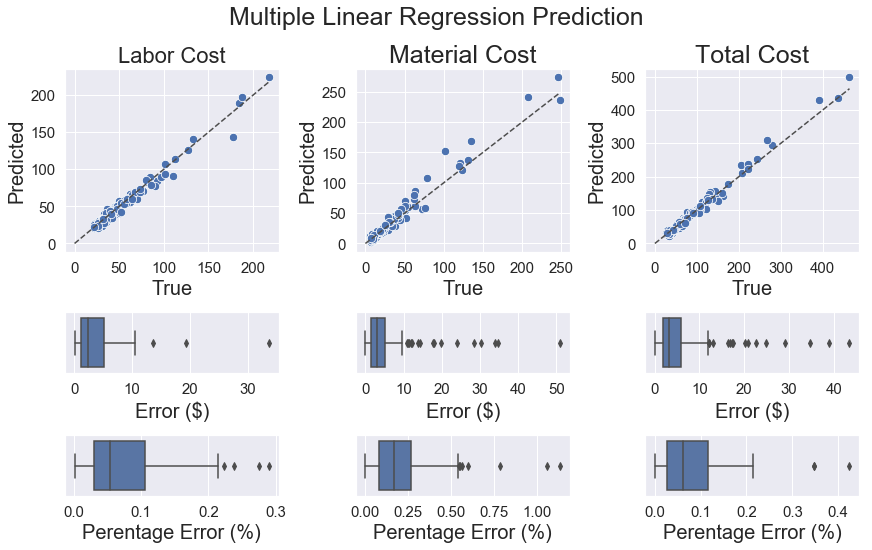

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(12, 7))
gs = fig.add_gridspec(5, 3)
fig.suptitle('Multiple Linear Regression Prediction', size=25, y=1.07)

# True v.s. Predicted
##################################################
fig_ax1 = fig.add_subplot(gs[0:3, 0])
sns.scatterplot(x=y_test_labor,
                y=regression_labor.predict(X_test),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Labor Cost', size=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_labor)], [0, np.max(y_test_labor)], ls="--", c=".3");


fig_ax2 = fig.add_subplot(gs[0:3, 1])
sns.scatterplot(x=y_test_material,
                y=regression_material.predict(X_test),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Material Cost', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_material)], [0, np.max(y_test_material)], ls="--", c=".3");


fig_ax3 = fig.add_subplot(gs[0:3, 2])
sns.scatterplot(x=y_test_total,
                y=regression_total.predict(X_test),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Total Cost', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_total)], [0, np.max(y_test_total)], ls="--", c=".3");



# Boxplot
##################################################
regression_error_labor = np.abs(y_test_labor - regression_labor.predict(X_test))
regression_error_percent_labor = np.abs(y_test_labor - regression_labor.predict(X_test)) / y_test_labor

regression_error_material = np.abs(y_test_material - regression_material.predict(X_test))
regression_error_percent_material = np.abs(y_test_material - regression_material.predict(X_test)) / y_test_material

regression_error_total = np.abs(y_test_total - regression_total.predict(X_test))
regression_error_percent_total = np.abs(y_test_total - regression_total.predict(X_test)) / y_test_total


fig_ax4 = fig.add_subplot(gs[3, 0])
sns.boxplot(x = regression_error_labor)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[3, 1])
sns.boxplot(x = regression_error_material)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[3, 2])
sns.boxplot(x = regression_error_total)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


fig_ax4 = fig.add_subplot(gs[4, 0])
sns.boxplot(x = regression_error_percent_labor)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[4, 1])
sns.boxplot(x=regression_error_percent_material)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[4, 2])
sns.boxplot(x=regression_error_percent_total)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

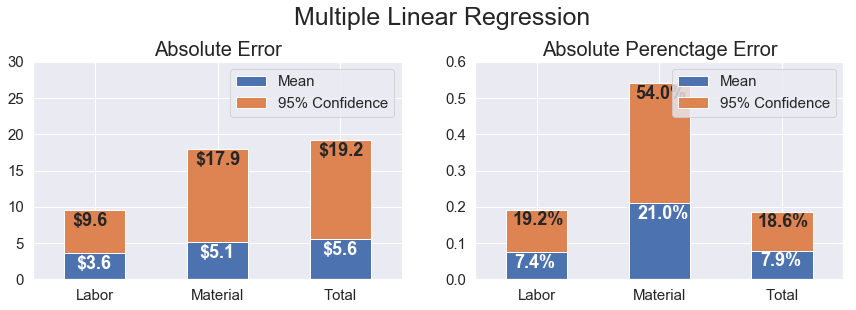

In [20]:
# Summary table
############################################################
regression_summary = pd.DataFrame({
    'Labor' : [np.mean(regression_error_labor),
               np.percentile(regression_error_labor, 95),
               np.mean(regression_error_percent_labor),
               np.percentile(regression_error_percent_labor, 95)],
    
    'Material' : [np.mean(regression_error_material),
               np.percentile(regression_error_material, 95),
               np.mean(regression_error_percent_material),
               np.percentile(regression_error_percent_material, 95)],
    
    'Total' : [np.mean(regression_error_total),
               np.percentile(regression_error_total, 95),
               np.mean(regression_error_percent_total),
               np.percentile(regression_error_percent_total, 95)]
})


regression_summary.rename(index={0 : 'MAE',
                             1 : '95% Confidence MAE',
                             2 : 'MAPE',
                             3 : '95% Confidence MAPE',},
                      inplace=True)


# Figure
############################################################
fig, axes = plt.subplots(1, 2)


regression_summary.loc['95% Confidence MAE', :] = regression_summary.loc['95% Confidence MAE', :] - regression_summary.loc['MAE',:]
ax1 = regression_summary.loc[['MAE', '95% Confidence MAE'], :].T.plot(ax=axes[0], kind="bar", stacked=True, rot=0)
for i, v in enumerate(regression_summary.loc['95% Confidence MAE', :] + regression_summary.loc['MAE',:]):
        ax1.text(i-0.18, v-2.2, '${:.1f}'.format(v), fontweight='bold', size=18)
for i, v in enumerate(regression_summary.loc['MAE']):
        ax1.text(i-0.15, v-2.2, '${:.1f}'.format(v), fontweight='bold', size=18, color='white')
ax1.set_title('Absolute Error', size=20)
ax1.legend(['Mean', '95% Confidence'], prop={'size': 15})
ax1.set_ylim(0, 30)
ax1.tick_params(axis='both', which='major', labelsize=15)


plt.subplots_adjust(right=2)

regression_summary.loc['95% Confidence MAPE', :] = regression_summary.loc['95% Confidence MAPE', :] - regression_summary.loc['MAPE',:]
ax2 = regression_summary.loc[['MAPE', '95% Confidence MAPE'], :].T.plot(ax=axes[1], kind="bar", stacked=True, rot=0)
for i, v in enumerate(regression_summary.loc['95% Confidence MAPE', :] + regression_summary.loc['MAPE',:]):
        ax2.text(i-0.2, v-0.042, '{:.1f}%'.format(v*100), fontweight='bold', size=18)
for i, v in enumerate(regression_summary.loc['MAPE']):
        ax2.text(i-0.18, v-0.042, '{:.1f}%'.format(v*100), fontweight='bold', size=18, color='white');
ax2.set_title('Absolute Perenctage Error', size=20)
ax2.legend(['Mean', '95% Confidence'], prop={'size': 15})
ax2.set_ylim(0, 0.6)
ax2.tick_params(axis='both', which='major', labelsize=15)


plt.suptitle('Multiple Linear Regression', size=25, y=1.07, x=1.07);

In [21]:
a = pd.DataFrame({'total_by_sum':round(regression_labor.predict(X_test) + regression_material.predict(X_test), 2),
                  'total_by_direct_regression':round(regression_total.predict(X_test), 2)})
a.head()

,total_by_sum,total_by_direct_regression
290,58.50,58.50
331,498.17,498.17
227,122.99,122.99
528,29.14,29.14
158,58.94,58.94


### Interactive figure

In [22]:
reference_X.describe()

,Material Fly Weight [kg],Length,Width,Projected Area Ratio,Projected Height,Material density,Nb of bonding point [Qty],Finished part Volume,Material Removed Pockets,Material Removed Final
count,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,738.000000,7.380000e+02,738.000000,738.000000
mean,0.465906,268.093248,136.285031,0.759554,33.367978,2.799472,0.086721,1.816404e+05,1.060935,2.111896
std,0.885930,161.270911,85.545386,0.181122,27.836593,0.007557,0.541932,4.877951e+05,2.984247,5.247443
min,0.003600,45.000000,30.843639,0.116193,2.160075,2.710000,0.000000,1.012118e+02,0.000000,0.000000
25%,0.073250,147.797074,74.625065,0.635914,11.000000,2.800000,0.000000,2.529702e+04,0.000000,0.085220
50%,0.158700,228.878894,104.962213,0.781783,28.089211,2.800000,0.000000,5.702975e+04,0.008633,0.404666
75%,0.521900,364.711442,181.117806,0.926418,46.958927,2.800000,0.000000,1.832623e+05,0.756254,1.792808
max,15.232200,705.018941,504.282112,1.000000,187.731067,2.830000,8.000000,9.871891e+06,38.381189,90.175064


In [23]:
def cost(X1, X2, X3, X4, X5, X6, X7, X8, X9, X10):
    
    X = [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10]
    
    ########################### Cost plot
    labor = regression_labor.predict(X)[0]
    material = regression_material.predict(X)[0]
    total = regression_total.predict(X)[0]
    
    plt.figure(figsize=(7, 4))
    ax = sns.barplot(x=['Labor', 'Material', 'Total'],
                     y=[labor, material, total])
    plt.title('Predicted Costs', size=20);
    for i, v in enumerate([labor, material, total]):
        ax.text(i-0.1, v+0.9, '${:.1f}'.format(v), fontweight='bold', size=13)
        
    ######################### Technical Driver plot
    var_input_dict = dict({'X1':X1, 'X2':X2, 'X3':X3, 'X4':X4, 'X5':X5, 'X6':X6, 'X7':X7, 'X8':X8, 'X9':X9, 'X10':X10})

    plt.figure(figsize=(7.5, 4.5))
    for i in enumerate(reference_X.columns):
        plt.subplot(5, 2, i[0] + 1)
        plt.subplots_adjust(hspace=2)
        sns.boxplot(reference_num[i[1]])
        plt.axvline(x=var_input_dict['X'+str(i[0] + 1)], color='red')
        plt.xticks([]),plt.yticks([])
        
        
style = {'description_width': '200px'}
layout = {'width': '450px', 'height': '50px'}        

widget = interactive(cost,
    
    X1 = widgets.FloatSlider(
        value=round(np.median(reference[reference_X.columns[0]]), 2),
        min=0,
        max=10,
        step=0.01,
        description=reference_X.columns[0] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X2 = widgets.IntSlider(
        value=round(np.median(reference[reference_X.columns[1]])),
        min=round(np.min(reference[reference_X.columns[1]])),
        max=round(np.max(reference[reference_X.columns[1]])),
        step=10,
        description=reference_X.columns[1] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X3 = widgets.IntSlider(
        value=round(np.median(reference[reference_X.columns[2]])),
        min=round(np.min(reference[reference_X.columns[2]])),
        max=round(np.max(reference[reference_X.columns[2]])),
        step=10,
        description=reference_X.columns[2] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X4 = widgets.FloatSlider(
        value=round(np.median(reference[reference_X.columns[3]]), 2),
        min=0,
        max=1,
        step=0.01,
        description=reference_X.columns[3] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X5 = widgets.IntSlider(
        value=round(np.median(reference[reference_X.columns[4]])),
        min=0,
        max=round(np.max(reference[reference_X.columns[4]])),
        step=10,
        description=reference_X.columns[4] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X6 = widgets.FloatSlider(
        value=round(np.median(reference[reference_X.columns[5]]), 2),
        min=round(np.min(reference[reference_X.columns[5]]), 2),
        max=round(np.max(reference[reference_X.columns[5]]), 2),
        step=0.01,
        description=reference_X.columns[5] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X7 = widgets.IntSlider(
        value=round(np.median(reference[reference_X.columns[6]])),
        min=round(np.min(reference[reference_X.columns[6]])),
        max=round(np.max(reference[reference_X.columns[6]])),
        step=1,
        description=reference_X.columns[6] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X8 = widgets.IntSlider(
        value=round(np.median(reference[reference_X.columns[7]])),
        min=0,
        max=round(np.max(reference[reference_X.columns[7]])),
        step=10000,
        description=reference_X.columns[7] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X9 = widgets.IntSlider(
        value=round(np.median(reference[reference_X.columns[8]])),
        min=0,
        max=40,
        step=1,
        description=reference_X.columns[8] + ':',
        continuous_update=False,
        style=style,
        layout=layout),
    
    X10 = widgets.IntSlider(
        value=round(np.median(reference[reference_X.columns[9]])),
        min=0,
        max=100,
        step=1,
        description=reference_X.columns[9] + ':',
        continuous_update=False,
        style=style,
        layout=layout)
)


controls = VBox(widget.children[:-1], layout={'width': '500px'})
output = widget.children[-1]
display(HBox([controls, output]))

# =============================================================

# Random Forest

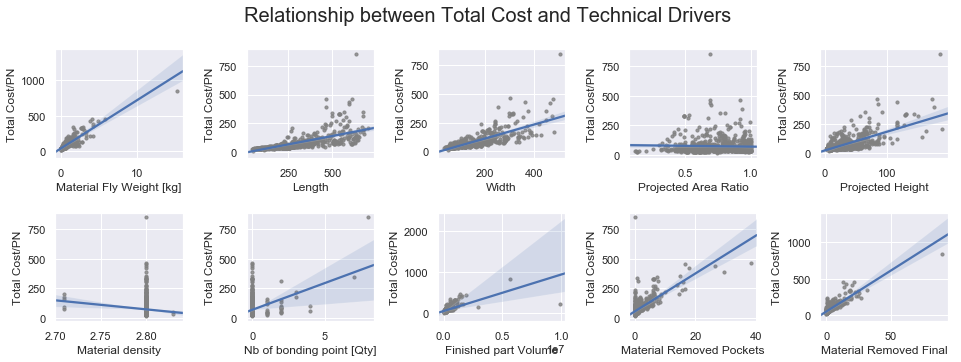

In [24]:
plt.figure(figsize=(16, 5))
for i in enumerate(reference_X):
    plt.subplot(2, 5, i[0]+1)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.regplot(y=reference['Total Cost/PN'],
                x=i[1],
                scatter_kws={'s':10, 'color':'grey'},
                data=reference_X)
plt.suptitle('Relationship between Total Cost and Technical Drivers', size=20, y=1);

Some technical drivers seem not have linear relationship with Costs (e.g. Projected Area Ratio). Other models may capture better the data.

In [25]:
# Random forest for Labor
forest_labor = RandomForestRegressor(random_state=42, criterion='mae', n_estimators=1000)
forest_labor_grid = GridSearchCV(forest_labor,
                                 param_grid={'max_features': [0.3, 0.5, 0.7],
                                             'max_depth': [None, 10, 20, 30]},
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True,
                                 cv=10)

# Random forest for Material
forest_material = RandomForestRegressor(random_state=42, criterion='mae', n_estimators=1000)
forest_material_grid = GridSearchCV(forest_material,
                                 param_grid={'max_features': [0.3, 0.5, 0.7],
                                             'max_depth': [None, 10, 20, 30]},
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True,
                                 cv=10)

# Random forest for Total
forest_total = RandomForestRegressor(random_state=42, criterion='mae', n_estimators=1000)
forest_total_grid = GridSearchCV(forest_total,
                                 param_grid={'max_features': [0.3, 0.5, 0.7],
                                             'max_depth': [None, 10, 20, 30]},
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True,
                                 cv=10)

In [26]:
forest_labor_grid = joblib.load('02_In_Progress/forest_labor_grid.pkl')
forest_material_grid = joblib.load('02_In_Progress/forest_material_grid.pkl')
forest_total_grid = joblib.load('02_In_Progress/forest_total_grid.pkl')

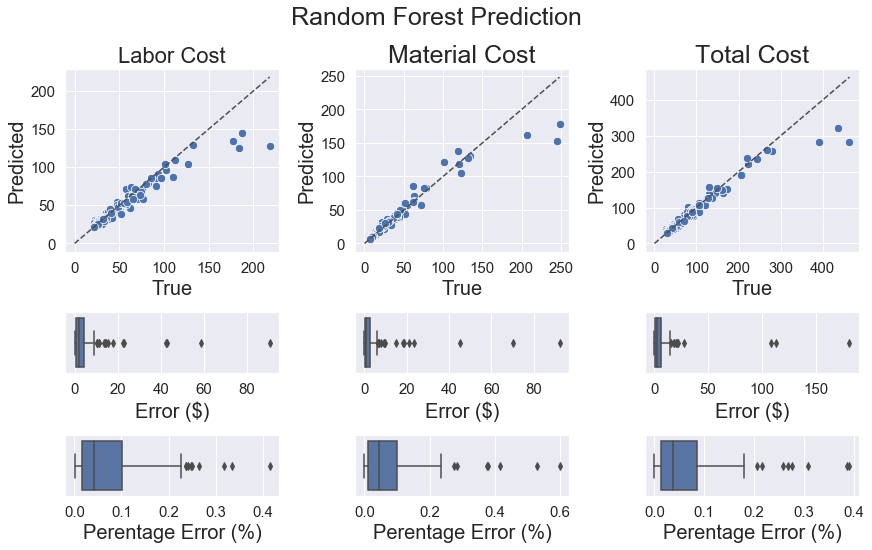

In [27]:
fig = plt.figure(constrained_layout=True, figsize=(12, 7))
gs = fig.add_gridspec(5, 3)
fig.suptitle('Random Forest Prediction', size=25, y=1.07)

# True v.s. Predicted
##################################################
fig_ax1 = fig.add_subplot(gs[0:3, 0])
sns.scatterplot(x=y_test_labor,
                y=forest_labor_grid.best_estimator_.predict(X_test),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Labor Cost', size=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_labor)], [0, np.max(y_test_labor)], ls="--", c=".3");


fig_ax2 = fig.add_subplot(gs[0:3, 1])
sns.scatterplot(x=y_test_material,
                y=forest_material_grid.best_estimator_.predict(X_test),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Material Cost', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_material)], [0, np.max(y_test_material)], ls="--", c=".3");


fig_ax3 = fig.add_subplot(gs[0:3, 2])
sns.scatterplot(x=y_test_total,
                y=forest_total_grid.best_estimator_.predict(X_test),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Total Cost', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_total)], [0, np.max(y_test_total)], ls="--", c=".3");



# Boxplot
##################################################
forest_error_labor = np.abs(y_test_labor - forest_labor_grid.best_estimator_.predict(X_test))
forest_error_percent_labor = np.abs(y_test_labor - forest_labor_grid.best_estimator_.predict(X_test)) / y_test_labor

forest_error_material = np.abs(y_test_material - forest_material_grid.best_estimator_.predict(X_test))
forest_error_percent_material = np.abs(y_test_material - forest_material_grid.best_estimator_.predict(X_test)) / y_test_material

forest_error_total = np.abs(y_test_total - forest_total_grid.best_estimator_.predict(X_test))
forest_error_percent_total = np.abs(y_test_total - forest_total_grid.best_estimator_.predict(X_test)) / y_test_total


fig_ax4 = fig.add_subplot(gs[3, 0])
sns.boxplot(x = forest_error_labor)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[3, 1])
sns.boxplot(x = forest_error_material)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[3, 2])
sns.boxplot(x = forest_error_total)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


fig_ax4 = fig.add_subplot(gs[4, 0])
sns.boxplot(x = forest_error_percent_labor)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[4, 1])
sns.boxplot(x=forest_error_percent_material)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[4, 2])
sns.boxplot(x=forest_error_percent_total)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

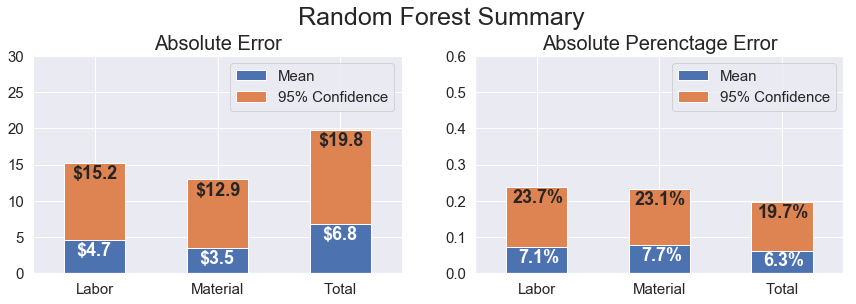

In [28]:
# Summary table
############################################################
forest_summary = pd.DataFrame({
    'Labor' : [np.mean(forest_error_labor),
               np.percentile(forest_error_labor, 95),
               np.mean(forest_error_percent_labor),
               np.percentile(forest_error_percent_labor, 95)],
    
    'Material' : [np.mean(forest_error_material),
               np.percentile(forest_error_material, 95),
               np.mean(forest_error_percent_material),
               np.percentile(forest_error_percent_material, 95)],
    
    'Total' : [np.mean(forest_error_total),
               np.percentile(forest_error_total, 95),
               np.mean(forest_error_percent_total),
               np.percentile(forest_error_percent_total, 95)]
})


forest_summary.rename(index={0 : 'MAE',
                             1 : '95% Confidence MAE',
                             2 : 'MAPE',
                             3 : '95% Confidence MAPE',},
                      inplace=True)


# Figure
############################################################
fig, axes = plt.subplots(1, 2)


forest_summary.loc['95% Confidence MAE', :] = forest_summary.loc['95% Confidence MAE', :] - forest_summary.loc['MAE',:]
ax1 = forest_summary.loc[['MAE', '95% Confidence MAE'], :].T.plot(ax=axes[0], kind="bar", stacked=True, rot=0)
for i, v in enumerate(forest_summary.loc['95% Confidence MAE', :] + forest_summary.loc['MAE',:]):
        ax1.text(i-0.18, v-2.2, '${:.1f}'.format(v), fontweight='bold', size=18)
for i, v in enumerate(forest_summary.loc['MAE']):
        ax1.text(i-0.15, v-2.2, '${:.1f}'.format(v), fontweight='bold', size=18, color='white')
ax1.set_title('Absolute Error', size=20)
ax1.legend(['Mean', '95% Confidence'], prop={'size': 15})
ax1.set_ylim(0, 30)
ax1.tick_params(axis='both', which='major', labelsize=15)


plt.subplots_adjust(right=2)

forest_summary.loc['95% Confidence MAPE', :] = forest_summary.loc['95% Confidence MAPE', :] - forest_summary.loc['MAPE',:]
ax2 = forest_summary.loc[['MAPE', '95% Confidence MAPE'], :].T.plot(ax=axes[1], kind="bar", stacked=True, rot=0)
for i, v in enumerate(forest_summary.loc['95% Confidence MAPE', :] + forest_summary.loc['MAPE',:]):
        ax2.text(i-0.2, v-0.042, '{:.1f}%'.format(v*100), fontweight='bold', size=18)
for i, v in enumerate(forest_summary.loc['MAPE']):
        ax2.text(i-0.15, v-0.042, '{:.1f}%'.format(v*100), fontweight='bold', size=18, color='white');
ax2.set_title('Absolute Perenctage Error', size=20)
ax2.legend(['Mean', '95% Confidence'], prop={'size': 15})
ax2.set_ylim(0, 0.6)
ax2.tick_params(axis='both', which='major', labelsize=15)


plt.suptitle('Random Forest Summary', size=25, y=1.05, x=1.07);

# =============================================================

# Neural Network

In [29]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

In [30]:
# Neural Network for Labor
mlp_labor = MLPRegressor(random_state=42, max_iter=50000)
mlp_labor_grid = GridSearchCV(mlp_labor,
                                 param_grid={'hidden_layer_sizes': [(5), (10), (15),
                                                                    (5, 5), (10, 10), (15, 15),
                                                                    (5, 5, 5), (10, 10, 10), (15, 15, 15)],
                                            'alpha': [1e+01, 5e+01, 1e+02]},
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True,
                                 cv=10)

# Neural Network for Material
mlp_material = MLPRegressor(random_state=42, max_iter=50000)
mlp_material_grid = GridSearchCV(mlp_material,
                                 param_grid={'hidden_layer_sizes': [(5), (10), (15),
                                                                    (5, 5), (10, 10), (15, 15),
                                                                    (5, 5, 5), (10, 10, 10), (15, 15, 15)],
                                            'alpha': [1e+01, 5e+01, 1e+02]},
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True,
                                 cv=10)

# Neural Network for Total
mlp_total = MLPRegressor(random_state=42, max_iter=50000)
mlp_total_grid = GridSearchCV(mlp_total,
                                 param_grid={'hidden_layer_sizes': [(5), (10), (15),
                                                                    (5, 5), (10, 10), (15, 15),
                                                                    (5, 5, 5), (10, 10, 10), (15, 15, 15)],
                                            'alpha': [1e+01, 5e+01, 1e+02]},
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True,
                                 cv=10)

In [31]:
mlp_labor_grid = joblib.load('02_In_Progress/mlp_labor_grid.pkl')
mlp_material_grid = joblib.load('02_In_Progress/mlp_material_grid.pkl')
mlp_total_grid = joblib.load('02_In_Progress/mlp_total_grid.pkl')

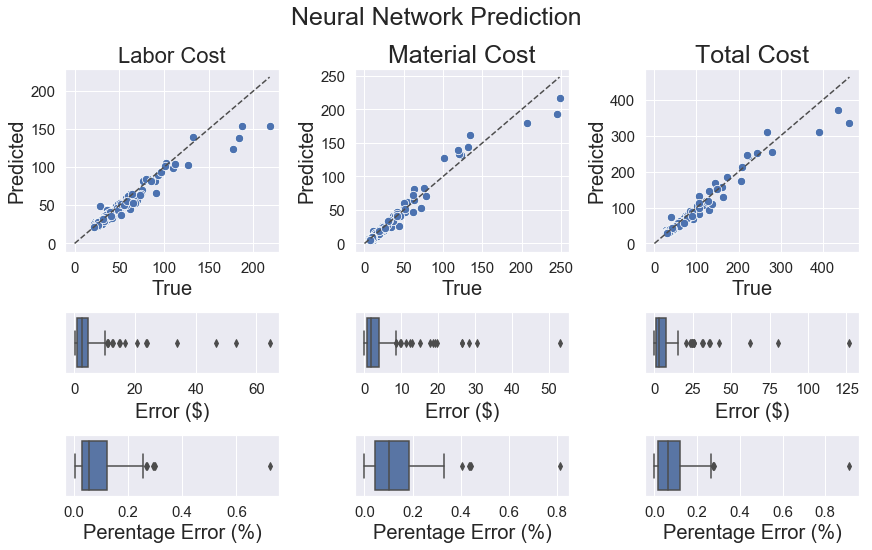

In [32]:
fig = plt.figure(constrained_layout=True, figsize=(12, 7))
gs = fig.add_gridspec(5, 3)
fig.suptitle('Neural Network Prediction', size=25, y=1.07)

# True v.s. Predicted
##################################################
fig_ax1 = fig.add_subplot(gs[0:3, 0])
sns.scatterplot(x=y_test_labor,
                y=mlp_labor_grid.best_estimator_.predict(X_test_scale),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Labor Cost', size=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_labor)], [0, np.max(y_test_labor)], ls="--", c=".3");


fig_ax2 = fig.add_subplot(gs[0:3, 1])
sns.scatterplot(x=y_test_material,
                y=mlp_material_grid.best_estimator_.predict(X_test_scale),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Material Cost', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_material)], [0, np.max(y_test_material)], ls="--", c=".3");


fig_ax3 = fig.add_subplot(gs[0:3, 2])
sns.scatterplot(x=y_test_total,
                y=mlp_total_grid.best_estimator_.predict(X_test_scale),
                s=70);
plt.xlabel('True', size=20)
plt.ylabel('Predicted', size=20)
plt.title('Total Cost', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, np.max(y_test_total)], [0, np.max(y_test_total)], ls="--", c=".3");



# Boxplot
##################################################
mlp_error_labor = np.abs(y_test_labor - mlp_labor_grid.best_estimator_.predict(X_test_scale))
mlp_error_percent_labor = np.abs(y_test_labor - mlp_labor_grid.best_estimator_.predict(X_test_scale)) / y_test_labor

mlp_error_material = np.abs(y_test_material - mlp_material_grid.best_estimator_.predict(X_test_scale))
mlp_error_percent_material = np.abs(y_test_material - mlp_material_grid.best_estimator_.predict(X_test_scale)) / y_test_material

mlp_error_total = np.abs(y_test_total - mlp_total_grid.best_estimator_.predict(X_test_scale))
mlp_error_percent_total = np.abs(y_test_total - mlp_total_grid.best_estimator_.predict(X_test_scale)) / y_test_total


fig_ax4 = fig.add_subplot(gs[3, 0])
sns.boxplot(x = mlp_error_labor)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[3, 1])
sns.boxplot(x = mlp_error_material)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[3, 2])
sns.boxplot(x = mlp_error_total)
plt.xlabel('Error ($)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


fig_ax4 = fig.add_subplot(gs[4, 0])
sns.boxplot(x = mlp_error_percent_labor)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[4, 1])
sns.boxplot(x=mlp_error_percent_material)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_ax4 = fig.add_subplot(gs[4, 2])
sns.boxplot(x=mlp_error_percent_total)
plt.xlabel('Perentage Error (%)', size=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

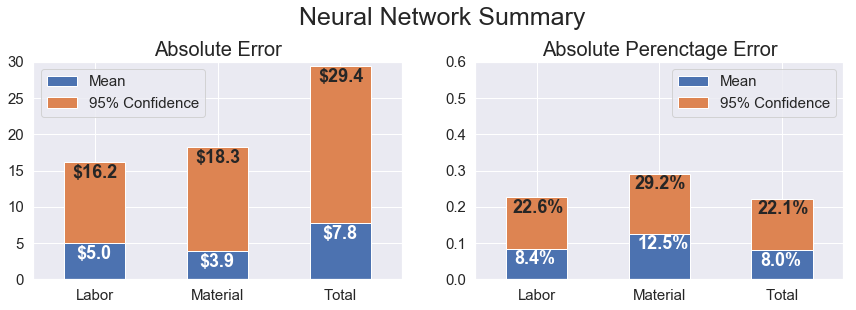

In [33]:
# Summary table
############################################################
mlp_summary = pd.DataFrame({
    'Labor' : [np.mean(mlp_error_labor),
               np.percentile(mlp_error_labor, 95),
               np.mean(mlp_error_percent_labor),
               np.percentile(mlp_error_percent_labor, 95)],
    
    'Material' : [np.mean(mlp_error_material),
               np.percentile(mlp_error_material, 95),
               np.mean(mlp_error_percent_material),
               np.percentile(mlp_error_percent_material, 95)],
    
    'Total' : [np.mean(mlp_error_total),
               np.percentile(mlp_error_total, 95),
               np.mean(mlp_error_percent_total),
               np.percentile(mlp_error_percent_total, 95)]
})


mlp_summary.rename(index={0 : 'MAE',
                             1 : '95% Confidence MAE',
                             2 : 'MAPE',
                             3 : '95% Confidence MAPE',},
                      inplace=True)


# Figure
############################################################
fig, axes = plt.subplots(1, 2)


mlp_summary.loc['95% Confidence MAE', :] = mlp_summary.loc['95% Confidence MAE', :] - mlp_summary.loc['MAE',:]
ax1 = mlp_summary.loc[['MAE', '95% Confidence MAE'], :].T.plot(ax=axes[0], kind="bar", stacked=True, rot=0)
for i, v in enumerate(mlp_summary.loc['95% Confidence MAE', :] + mlp_summary.loc['MAE',:]):
        ax1.text(i-0.18, v-2.2, '${:.1f}'.format(v), fontweight='bold', size=18)
for i, v in enumerate(mlp_summary.loc['MAE']):
        ax1.text(i-0.15, v-2.2, '${:.1f}'.format(v), fontweight='bold', size=18, color='white')
ax1.set_title('Absolute Error', size=20)
ax1.legend(['Mean', '95% Confidence'], prop={'size': 15})
ax1.set_ylim(0, 30)
ax1.tick_params(axis='both', which='major', labelsize=15)


plt.subplots_adjust(right=2)

mlp_summary.loc['95% Confidence MAPE', :] = mlp_summary.loc['95% Confidence MAPE', :] - mlp_summary.loc['MAPE',:]
ax2 = mlp_summary.loc[['MAPE', '95% Confidence MAPE'], :].T.plot(ax=axes[1], kind="bar", stacked=True, rot=0)
for i, v in enumerate(mlp_summary.loc['95% Confidence MAPE', :] + mlp_summary.loc['MAPE',:]):
        ax2.text(i-0.2, v-0.042, '{:.1f}%'.format(v*100), fontweight='bold', size=18)
for i, v in enumerate(mlp_summary.loc['MAPE']):
        ax2.text(i-0.18, v-0.042, '{:.1f}%'.format(v*100), fontweight='bold', size=18, color='white');
ax2.set_title('Absolute Perenctage Error', size=20)
ax2.legend(['Mean', '95% Confidence'], prop={'size': 15})
ax2.set_ylim(0, 0.6)
ax2.tick_params(axis='both', which='major', labelsize=15)


plt.suptitle('Neural Network Summary', size=25, y=1.07, x=1.07);

# =============================================================

# Degree of confidence on 'Test samples.xlsx'

In [34]:
test_sample1 = pd.read_excel('01_Input/Test samples.xlsx', sheet_name='Costing Detail')
test_sample1 = test_sample1[['partNumber', 'Total Labor Cost/PN', 'Total Material Cost/PN', 'Total Cost/PN']]
test_sample1.partNumber = test_sample1.partNumber.str.lower()
test_sample2 = pd.read_excel('01_Input/Test samples.xlsx', sheet_name='Tech. Drivers')
test_sample = pd.merge(test_sample1, test_sample2, how='left', left_on='partNumber', right_on='partNumber')
test_sample_X = test_sample[reference_X.columns] # keep only relevant columns
test_sample_X = test_sample_X.fillna(test_sample_X.median())
test_sample_X.index = test_sample1['partNumber']

test_sample_labor = test_sample['Total Labor Cost/PN']
test_sample_labor.index = test_sample1['partNumber']

test_sample_material = test_sample['Total Material Cost/PN']
test_sample_material.index = test_sample1['partNumber']


test_sample_total = test_sample['Total Cost/PN']
test_sample_total.index = test_sample1['partNumber']

test_sample_X.head()

,Material Fly Weight [kg],Length,Width,Projected Area Ratio,Projected Height,Material density,Nb of bonding point [Qty],Finished part Volume,Material Removed Pockets,Material Removed Final
partNumber,,,,,,,,,,
x00001,0.7648,365.3418,155.0842,0.7668,50.84,2.8,7,254142.4762,1.709929,2.617473
x00002,0.7648,365.3418,155.0842,0.7668,50.84,2.8,7,254215.0162,1.709929,2.617473
x00003,0.7215,337.9157,152.5682,0.7774,51.34,2.8,0,253987.0521,1.552693,2.435510
x00004,0.7215,337.9157,152.5682,0.7774,51.34,2.8,0,253987.0586,1.552693,2.435619
x00005,0.6705,310.4920,152.0144,0.7905,51.34,2.8,0,236023.4183,1.444077,2.243045


In [35]:
confidence_labor = pd.DataFrame({'test':test_sample_labor,
                                 'predict':regression_labor.predict(test_sample_X)})
confidence_labor['confidence'] = np.minimum.reduce(np.asarray(list([confidence_labor['test'], confidence_labor['predict']]))) / \
    np.maximum.reduce(np.asarray(list([confidence_labor['test'], confidence_labor['predict']])))
# confidence_labor.head()


confidence_material = pd.DataFrame({'test':test_sample_material,
                                    'predict':forest_material_grid.best_estimator_.predict(test_sample_X)})
confidence_material['confidence'] = np.minimum.reduce(np.asarray(list([confidence_material['test'], confidence_material['predict']]))) / \
    np.maximum.reduce(np.asarray(list([confidence_material['test'], confidence_material['predict']])))
# confidence_material.head()


confidence_total = pd.DataFrame({'test':test_sample_total,
                                    'predict':regression_total.predict(test_sample_X)})
confidence_total['confidence'] = np.minimum.reduce(np.asarray(list([confidence_total['test'], confidence_total['predict']]))) / \
    np.maximum.reduce(np.asarray(list([confidence_total['test'], confidence_total['predict']])))
# confidence_total.head()

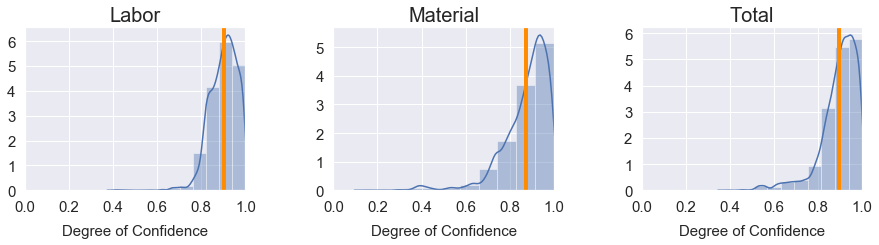

In [36]:
plt.figure(figsize=(15, 3))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1, 3, 1)
sns.distplot(confidence_labor.confidence, bins=10)
plt.axvline(x=confidence_labor.confidence.mean(), color='darkorange', linewidth=4)
plt.xlabel('Degree of Confidence', size=15, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0, 1)
plt.title('Labor', size=20);

plt.subplot(1, 3, 2)
sns.distplot(confidence_material.confidence, bins=10)
plt.axvline(x=confidence_material.confidence.mean(), color='darkorange', linewidth=4)
plt.xlabel('Degree of Confidence', size=15, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0, 1)
plt.title('Material', size=20);

plt.subplot(1, 3, 3)
sns.distplot(confidence_total.confidence, bins=10)
plt.axvline(x=confidence_total.confidence.mean(), color='darkorange', linewidth=4)
plt.xlabel('Degree of Confidence', size=15, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0, 1)
plt.title('Total', size=20);